In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# A Simple Starter Code for the AJL Competition

@Cindy Deng

---


Hi! This starter code is designed to help you get familiar with basic Kaggle operations and guide you through the basic workflow of a machine learning project. 

The code outlines essential steps including data loading, preprocessing, model building, training, and generating predictions. Each section serves as a foundation, but there are many ways to enhance each step to improve your final model's accuracy. Feel free to experiment with different data augmentation techniques, model architectures, and tuning methods to optimize your final results! Some amazing tutorials are available through your AI Studio course in Canvas / in the 'Resource' section of this Kaggle competition.

Good luck and have fun!

---

## Note - About file path

You could use the cell above to print the names of the file directories and get the following directories:

```
/kaggle/input/bttai-ajl-2025/sample_submission.csv
/kaggle/input/bttai-ajl-2025/train.csv
/kaggle/input/bttai-ajl-2025/test.csv
/kaggle/input/bttai-ajl-2025/test/test/e0374ae6c1362ff183cfba28ded5421b.jpg
/kaggle/input/bttai-ajl-2025/test/test/437159c605260bdd079af230566af291.jpg
...
...
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/11271bdf2598afdd4260db3125e1f6a5.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/732819951dcf2b53d15ea7b8bb123b71.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/6dcc7a8abb5e1c6e670101f4b6231246.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/e63c3b3f0ab8905e204fe467cc7411f9.jpg
...
...
```



## 1. Import Necessary Libraries

In [2]:
# 1. Import Necessary Libraries
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
# Explanation:
# - pandas and numpy: for data manipulation
# - sklearn: for splitting data and encoding labels
# - tensorflow.keras: for building and training the neural network

## 2. Load Data

Make sure to verify the file paths if you're running on a different platform.

In [3]:
# 2. Load Data
train_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/train.csv')
test_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/test.csv')

# Add .jpg extension to md5hash column to reference the file_name
train_df['md5hash'] = train_df['md5hash'].astype(str) + '.jpg'
test_df['md5hash'] = test_df['md5hash'].astype(str) + '.jpg'

# Combine label and md5hash to form the correct path
train_df['file_path'] = train_df['label'] + '/' + train_df['md5hash']

In [4]:
# Check the first few rows to understand the structure
print(train_df.head())

                                md5hash  fitzpatrick_scale  \
0  fd06d13de341cc75ad679916c5d7e6a6.jpg                  4   
1  a4bb4e5206c4e89a303f470576fc5253.jpg                  1   
2  c94ce27e389f96bda998e7c3fa5c4a2e.jpg                  5   
3  ebcf2b50dd943c700d4e2b586fcd4425.jpg                  3   
4  c77d6c895f05fea73a8f3704307036c0.jpg                  1   

   fitzpatrick_centaur                             label nine_partition_label  \
0                    4                 prurigo-nodularis     benign-epidermal   
1                    1  basal-cell-carcinoma-morpheiform  malignant-epidermal   
2                    5                            keloid         inflammatory   
3                    3              basal-cell-carcinoma  malignant-epidermal   
4                    1                 prurigo-nodularis     benign-epidermal   

  three_partition_label            qc  ddi_scale  \
0                benign           NaN         34   
1             malignant           Na

In [5]:
qc_counts_train = train_df['qc'].value_counts(dropna=False)
qc_counts_test = test_df['qc'].value_counts(dropna=False)

# Display the results
print("The training set contains")
print(qc_counts_train)

print("The testing set contains")
print(qc_counts_test)

The training set contains
qc
NaN                   2770
1 Diagnostic            76
5 Potentially            7
3 Wrongly labelled       4
2 Characteristic         2
4 Other                  1
Name: count, dtype: int64
The testing set contains
qc
NaN                   1198
1 Diagnostic            24
5 Potentially            3
3 Wrongly labelled       1
2 Characteristic         1
Name: count, dtype: int64


In [6]:
print(train_df.info())
print("\nMissing Values:\n", train_df.isnull().sum())

print(test_df.info())
print("\nMissing Values:\n", test_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2860 entries, 0 to 2859
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   md5hash                2860 non-null   object
 1   fitzpatrick_scale      2860 non-null   int64 
 2   fitzpatrick_centaur    2860 non-null   int64 
 3   label                  2860 non-null   object
 4   nine_partition_label   2860 non-null   object
 5   three_partition_label  2860 non-null   object
 6   qc                     90 non-null     object
 7   ddi_scale              2860 non-null   int64 
 8   file_path              2860 non-null   object
dtypes: int64(3), object(6)
memory usage: 201.2+ KB
None

Missing Values:
 md5hash                     0
fitzpatrick_scale           0
fitzpatrick_centaur         0
label                       0
nine_partition_label        0
three_partition_label       0
qc                       2770
ddi_scale                   0
file_path         

In [7]:
print(train_df.describe())

       fitzpatrick_scale  fitzpatrick_centaur    ddi_scale
count        2860.000000          2860.000000  2860.000000
mean            2.524476             2.095455    23.547552
std             1.474428             1.510942    15.530522
min            -1.000000            -1.000000    -1.000000
25%             2.000000             1.000000    12.000000
50%             2.000000             2.000000    12.000000
75%             3.000000             3.000000    34.000000
max             6.000000             6.000000    56.000000


## 3. Data Preprocessing


This section demonstrates basic preprocessing techniques. To enhance data quality and model performance, consider incorporating more advanced preprocessing methods.

For further guidance, feel free to take a look at the [Image Preprocessing tutorial](https://colab.research.google.com/drive/1-ItNcRMbZBE6BCwPT-wD8m3YmHqwHxme?usp=sharing)  available in the 'Resources' section of this Kaggle competition.


First, examine the number of images for each class

In [8]:
# fitzpatrick_centaur and fitzpatrick_scale are both labels for the skin types (number from 1 to 6)
# fitzpatrick_scale is self labeled and fitzpatrick_centaur is labeled by a medical data annotation firm

# I want to see the difference between the 2 
np.average(train_df['fitzpatrick_scale'] - train_df['fitzpatrick_centaur'])
# There is a notable different, with fitzpatrick_scale on average being higher than fitzpatrick_centaur


# I will go with the fitzpatrick_centaur label since it is labeled by a professional medical data annotation firm

0.429020979020979

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


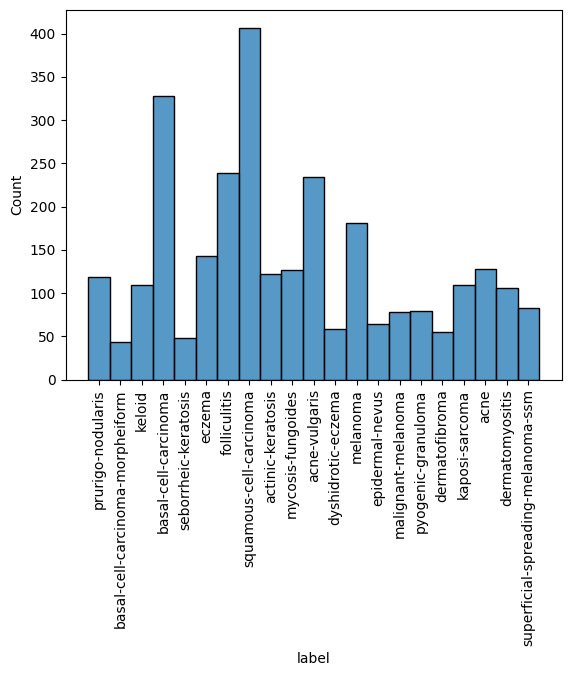

In [9]:
# Check the number images for each skin condition 
sns.histplot(train_df['label'])
plt.xticks(rotation = 90)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


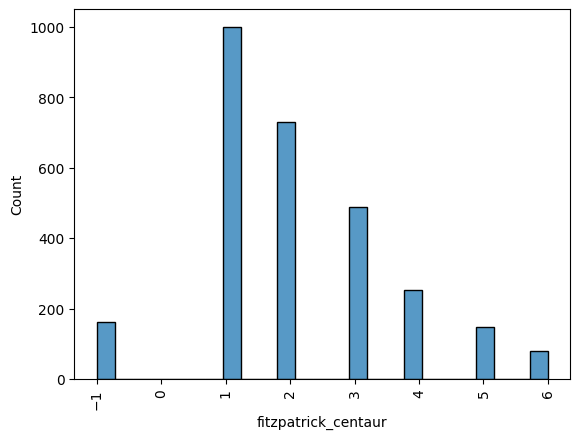

In [10]:
# Check the number images for each skin type
# -1 means unknown
sns.histplot(train_df['fitzpatrick_centaur'])
plt.xticks(rotation = 90)
plt.show()

In [11]:
# checking this with a cross tab
pd.crosstab(train_df['fitzpatrick_centaur'], train_df['label'])

label,acne,acne-vulgaris,actinic-keratosis,basal-cell-carcinoma,basal-cell-carcinoma-morpheiform,dermatofibroma,dermatomyositis,dyshidrotic-eczema,eczema,epidermal-nevus,...,kaposi-sarcoma,keloid,malignant-melanoma,melanoma,mycosis-fungoides,prurigo-nodularis,pyogenic-granuloma,seborrheic-keratosis,squamous-cell-carcinoma,superficial-spreading-melanoma-ssm
fitzpatrick_centaur,,,,,,,,,,,,,,,,,,,,,
-1,2,1,5,13,4,1,0,2,2,2,...,9,1,7,10,0,0,8,0,66,2
1,59,88,49,107,22,32,28,22,56,43,...,15,27,40,65,45,16,44,29,106,65
2,30,91,36,98,14,16,36,21,44,4,...,16,13,22,35,46,9,16,8,98,13
3,21,35,18,69,3,5,20,6,18,8,...,29,17,7,37,15,46,6,5,61,3
4,8,11,9,31,0,0,15,2,8,5,...,26,21,2,21,13,23,1,3,40,0
5,8,3,5,10,0,1,4,1,9,1,...,6,20,0,4,8,20,4,0,18,0
6,0,5,0,0,0,0,3,4,6,1,...,8,10,0,9,0,5,0,3,18,0


From the EDA, we can see that there are imbalances in the skin condition and skin type.
During the data preprocessing, we aim to do data augmentation to increase the number of samples for 

In [12]:
label_counts = train_df['label'].value_counts()

# print(label_counts)

threshold_label = 150
underrepresented_labels = label_counts[label_counts < threshold_label].index.tolist()

print("Underrepresented Labels:", underrepresented_labels)

Underrepresented Labels: ['eczema', 'acne', 'mycosis-fungoides', 'actinic-keratosis', 'prurigo-nodularis', 'kaposi-sarcoma', 'keloid', 'dermatomyositis', 'superficial-spreading-melanoma-ssm', 'pyogenic-granuloma', 'malignant-melanoma', 'epidermal-nevus', 'dyshidrotic-eczema', 'dermatofibroma', 'seborrheic-keratosis', 'basal-cell-carcinoma-morpheiform']


In [13]:
# Count occurrences for Fitzpatrick Scale
fitzpatrick_counts = train_df['fitzpatrick_scale'].value_counts()
print("Fitzpatrick Scale Counts:\n", fitzpatrick_counts)

# Count occurrences for Fitzpatrick Centaur
fitzpatrick_centaur_counts = train_df['fitzpatrick_centaur'].value_counts()
print("Fitzpatrick Centaur Counts:\n", fitzpatrick_centaur_counts)

underrepresented_skin_tones = [4, -1, 5, 6 ]
# based on threshold of 450 (around 10%) of dataset 
# true for both fitzpatrick_counts and fitzpatrick_centaur_counts

Fitzpatrick Scale Counts:
 fitzpatrick_scale
 2    964
 3    562
 1    528
 4    393
 5    216
-1    108
 6     89
Name: count, dtype: int64
Fitzpatrick Centaur Counts:
 fitzpatrick_centaur
 1    1000
 2     730
 3     489
 4     253
-1     161
 5     147
 6      80
Name: count, dtype: int64


In [14]:
# train_df["file_path"].head()

In [15]:
base_path = "../input/bttai-ajl-2025/train/train/"

train_df["full_path"] = base_path + train_df["file_path"]

train_df["full_path"].head()

0    ../input/bttai-ajl-2025/train/train/prurigo-no...
1    ../input/bttai-ajl-2025/train/train/basal-cell...
2    ../input/bttai-ajl-2025/train/train/keloid/c94...
3    ../input/bttai-ajl-2025/train/train/basal-cell...
4    ../input/bttai-ajl-2025/train/train/prurigo-no...
Name: full_path, dtype: object

In [16]:


# df_filtered = train_df[train_df['fitzpatrick_centaur'] == -1]

# num_images = min(20, len(df_filtered))  # Display up to 10 images

# fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
# if num_images == 1:
#     axes = [axes]  # Ensure it's iterable if only one image

# for ax, (_, row) in zip(axes, df_filtered.iterrows()):
#     image_path = row['full_path']  
#     if os.path.exists(image_path):
#         image = cv2.imread(image_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
#         ax.imshow(image)
#         ax.axis('off')
#     else:
#         ax.set_title("Image not found")
#         ax.axis('off')

# plt.show()


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# want to think through if these should be set differently 
# as what they're set to impacts what the images that are generated look like
augmenter = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

def augment_image(image_path):
    if not os.path.exists(image_path):
        return None  # Prevents error if file doesn't exist

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.expand_dims(image, axis=0)

    augmented_image = next(augmenter.flow(image, batch_size=1))[0].astype(np.uint8)
    return augmented_image


In [18]:
print(train_df.columns)


Index(['md5hash', 'fitzpatrick_scale', 'fitzpatrick_centaur', 'label',
       'nine_partition_label', 'three_partition_label', 'qc', 'ddi_scale',
       'file_path', 'full_path'],
      dtype='object')


In [26]:
# want to generate more images for underrpresented labels and for unnderrepresented fitzpatrick_scale values 
print("Before augmented data added, training set size is:", len(train_df))

augmented_dir = "/kaggle/working/augmented_images"
os.makedirs(augmented_dir, exist_ok=True)

augmented_data = []

for idx, row in train_df.iterrows():
    skin_tone = row['fitzpatrick_scale']
    label = row['label']

    if "_aug_" in row['file_path']:
        continue 
         
    if skin_tone in underrepresented_skin_tones or label in underrepresented_labels:
        original_path = row['full_path']

        if not os.path.exists(original_path):
            print(f" Warning: File not found - {original_path}")
            continue 
        
        image = cv2.imread(original_path)
        if image is None:
            print(f" Error: Could not load image {original_path}")
            continue  # Skip this image

        for i in range(2):  # Generate 2 augmented images per original
            augmented_image = augment_image(original_path)  # Apply augmentation
            
            if augmented_image is None:
                print(f" Warning: Augmentation returned None for {original_path}")
                continue  # Skip this image

            if ".jpg" in row['file_path']:
                new_filename = row['file_path'].replace('.jpg', f'_aug_{i}.jpg')
            else:
                new_filename = row['file_path'] + f'_aug_{i}.jpg'

            save_path = os.path.join(augmented_dir, new_filename)

            save_dir = os.path.dirname(save_path)
            os.makedirs(save_dir, exist_ok=True)

            cv2.imwrite(save_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

            if os.path.exists(save_path):
                augmented_data.append({
                    'md5hash': row['md5hash'],  
                    'fitzpatrick_scale': row['fitzpatrick_scale'],  
                    'fitzpatrick_centaur': row['fitzpatrick_centaur'],  
                    'label': row['label'],
                    'nine_partition_label': row['nine_partition_label'],  
                    'three_partition_label': row['three_partition_label'],  
                    'qc': row['qc'],  
                    'ddi_scale': row['ddi_scale'],  
                    'file_path': new_filename,  
                    'full_path': save_path  
                })
            else:
                print(f" Failed to save: {save_path}")


#  Merge with training dataset
augmented_df = pd.DataFrame(augmented_data)
train_df = pd.concat([train_df, augmented_df], ignore_index=True)

print(" Augmented data added. New training set size:", len(train_df))


Before augmented data added, training set size is: 2860
 Augmented data added. New training set size: 6580


In [27]:
augmented_dir = "/kaggle/working/augmented_images"

all_augmented_images = []

for label in os.listdir(augmented_dir):  # Iterate over each subdirectory (label)
    label_dir = os.path.join(augmented_dir, label)
    if os.path.isdir(label_dir):  # Ensure it's a directory
        images = os.listdir(label_dir)[:3]  # Get a few images from each class
        all_augmented_images.extend([os.path.join(label_dir, img) for img in images])

print("Sample Augmented Image Paths:", all_augmented_images[:10])

Sample Augmented Image Paths: ['/kaggle/working/augmented_images/squamous-cell-carcinoma/4ef4e764a2ae0de2bd5d15affdf8cc20_aug_1.jpg', '/kaggle/working/augmented_images/squamous-cell-carcinoma/99c09906cd9631d6ff648f680ce3c7a2_aug_1.jpg', '/kaggle/working/augmented_images/squamous-cell-carcinoma/b41744abc102ddd0ff8cc3b44ad39b01_aug_0.jpg', '/kaggle/working/augmented_images/melanoma/084d223d5918ec2ddae37f2f8061e23c_aug_0.jpg', '/kaggle/working/augmented_images/melanoma/889a8ed4164c01992b4981e78597a29a_aug_0.jpg', '/kaggle/working/augmented_images/melanoma/e668f37499adaead040d7d893e778cc7_aug_0.jpg', '/kaggle/working/augmented_images/basal-cell-carcinoma-morpheiform/0a5c59128959230b7b3005d277a7c8e6_aug_0.jpg', '/kaggle/working/augmented_images/basal-cell-carcinoma-morpheiform/576faa7eb74b377212e11c85847c41fb_aug_0.jpg', '/kaggle/working/augmented_images/basal-cell-carcinoma-morpheiform/b913934059b41d32282034a891466afb_aug_0.jpg', '/kaggle/working/augmented_images/kaposi-sarcoma/ab6f88d2735

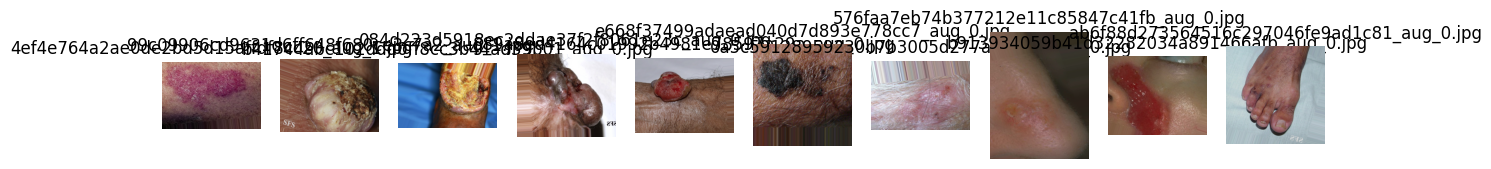

In [28]:
import cv2
import matplotlib.pyplot as plt

# Select up to 5 images to display
sample_images = all_augmented_images[:10]

fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))

for ax, img_path in zip(axes, sample_images):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(os.path.basename(img_path))

plt.show()

In [29]:
# augmented_images = os.listdir("/kaggle/working/augmented_images")[:10]  
# print(augmented_images)  

# print("Augmented images count in train_df:", len(train_df[train_df["full_path"].str.contains("_aug_")]))

# # Sample an image and check if it's None
# sample_path = train_df.iloc[0]["full_path"]
# augmented_image = augment_image(sample_path)

# if augmented_image is None or np.all(augmented_image == 0):
#     print("Augmentation function returned None or an empty image!")
# else:
#     print("Augmentation function is working correctly.")

print("Directory exists:", os.path.exists("/kaggle/working/augmented_images"))

# List contents of `/kaggle/working/`
print("Contents of /kaggle/working/:", os.listdir("/kaggle/working/"))

Directory exists: True
Contents of /kaggle/working/: ['.virtual_documents', 'augmented_images']


In [ ]:
# we should stratify sampling to make sure ratios are consistent among training and validating set 

In [50]:
# add all images to the augmented_images folder to make it consistent 
import shutil

temp_train_dir = '../input/bttai-ajl-2025/train/train/'

for root, dirs, files in os.walk(temp_train_dir): # loop through directories 
    for file in files:
        source = os.path.join(root,file)
        destination = os.path.join(augmented_dir, root.split('/')[-1])
        shutil.copy(source, destination)

In [51]:
# 3. Data Preprocessing
# Encode the labels
label_encoder = LabelEncoder()
train_df['encoded_label'] = label_encoder.fit_transform(train_df['label'])

# Split the data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Define image data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Define the directory paths
train_dir = '/kaggle/working/augmented_images'

In [52]:
def create_generator(dataframe, directory, batch_size=32, target_size=(128, 128)):
    """
    Template function to create image generators.
    Students should complete this function to load images and labels properly.
    """
    # Fill in the correct flow_from_dataframe parameters
    generator = train_datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col='file_path',  # Use combined path
        y_col='encoded_label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='raw',
        validate_filenames=False  # Disable strict filename validation
    )
    return generator

In [53]:
# Create generators
train_generator = create_generator(train_data, train_dir)
val_generator = create_generator(val_data, train_dir)

Found 5264 non-validated image filenames.
Found 1316 non-validated image filenames.


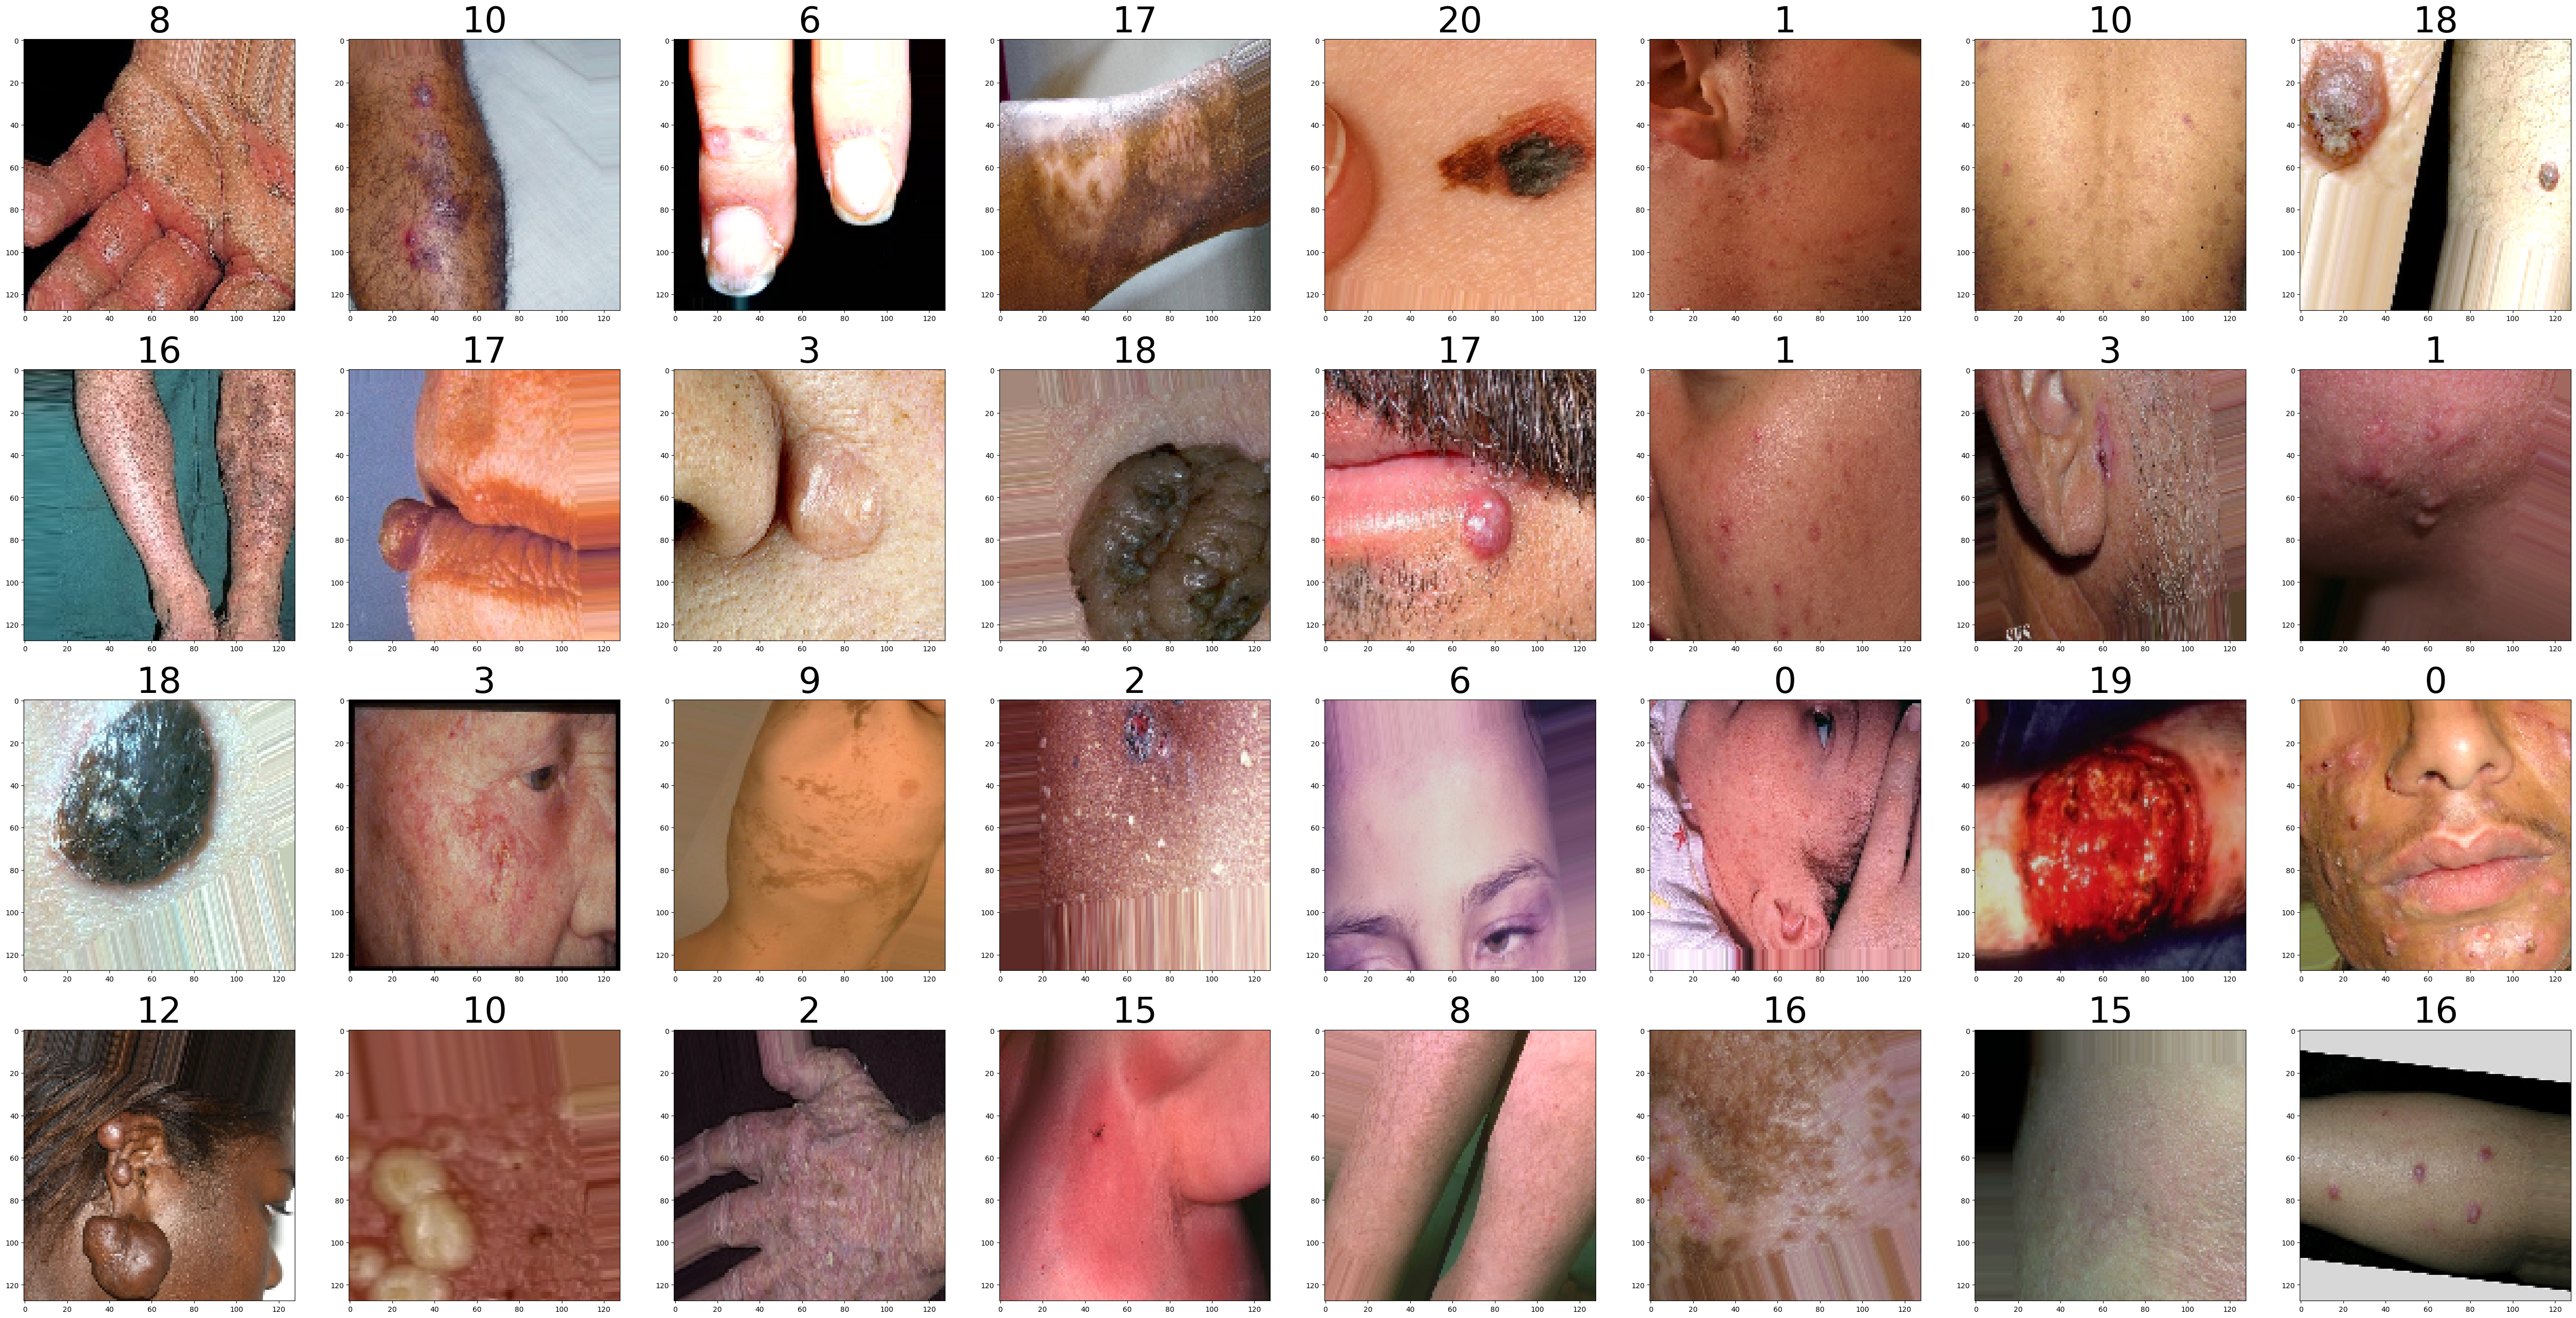

In [54]:
# show example of images
sample_img, sample_label = next(train_generator)

plt.figure(figsize=(64, 32)) 
for i in range (32): # 32 is just the batch size from before, change it if needed
    ax = plt.subplot(4, 8, i + 1) # I want the final result to be 4 x 8 images
    plt.imshow(sample_img[i])
    plt.title(sample_label[i], fontsize = 50 )
plt.show()
    

In [55]:
# check size of image 
input_shape = sample_img[0].shape
print(input_shape)

(128, 128, 3)


## 4. Build the model


In [88]:
# TODO: You should implement the model architecture here.
# Feel free to explore different model types that best serve your purpose.
from tensorflow.keras.applications import VGG19
import tensorflow as tf

model = VGG19(include_top=False, # I did not include the top layers because the pretrained model has different image size than what we have
    weights='imagenet',
    input_tensor=None,
    input_shape=input_shape,
    pooling=None,
    classes=21,
    classifier_activation='softmax')

# freeze the layers
for layer in model.layers:
    layer.trainable = False

# adding the dense layers 
# I used the configurations for the VGG 16 model 
# this way the last few layers will not have any starting weights
model = Sequential(layers = model.layers)
model.add(tf.keras.layers.Flatten(input_shape = input_shape))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(units = 4096, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(units = 4096, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = 21, activation = 'softmax'))

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 70,450,261 (268.75 MB)

 Trainable params: 50,425,877 (192.36 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

## 5. Train the Model


In [89]:
# TODO: Train your model here. 

# working pipeline is important as well
# cindy reccomends cnn as first case
model.fit(train_generator, validation_data = val_generator, epochs = 15)

Epoch 1/15
165/165 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - accuracy: 0.1054 - loss: 2.9667 - val_accuracy: 0.2378 - val_loss: 2.5112
Epoch 2/15
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.2627 - loss: 2.4459 - val_accuracy: 0.2188 - val_loss: 2.6180
Epoch 3/15
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.3250 - loss: 2.2321 - val_accuracy: 0.3374 - val_loss: 2.2009
Epoch 4/15
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.3807 - loss: 2.0591 - val_accuracy: 0.3138 - val_loss: 2.3141
Epoch 5/15
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.4240 - loss: 1.8726 - val_accuracy: 0.3488 - val_loss: 2.1466
Epoch 6/15
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.4535 - loss: 1.7724 - val_accuracy: 0.3883 - val_loss: 2.0655
Epoch 7/15
165/165 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.5151 - loss: 1.5839 - val_accuracy: 0.3746 - val_loss: 2.1737
Epoch 8/15
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.5462 - loss: 1

## 6. Make Predictions on Test Data

In [90]:
# 6. Make Predictions on Test Data
def preprocess_test_data(test_df, directory):
    """
    Template for loading and preprocessing test images.
    """
    # TODO: create a generator for the test set here.
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        ## set the test_generator here 
        dataframe = test_df, 
        directory = directory,
        x_col = 'md5hash',
        batch_size = 32, 
        target_size=(128, 128),
        class_mode=None
    )
    return test_generator
    

In [91]:
# Load test data
test_dir = '/kaggle/input/bttai-ajl-2025/test/test/'
test_generator = preprocess_test_data(test_df, test_dir)

Found 1227 validated image filenames.


## 7. Generate Predictions

In [92]:
# TODO
# Generate predictions based on the trained model
# Then, save the predictions into a CSV file for submission
probs = model.predict(test_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step


In [93]:
preds = probs.argmax(axis=1)

In [94]:
preds = label_encoder.inverse_transform(preds)
preds

array(['mycosis-fungoides', 'basal-cell-carcinoma',
       'superficial-spreading-melanoma-ssm', ..., 'eczema',
       'basal-cell-carcinoma', 'folliculitis'], dtype=object)

In [95]:
with open('final_preds.csv', 'w') as f:
    f.write('md5hash,label\n')
    for i in range(len(preds)):
        f.write(str(test_df['md5hash'][i].split(".")[0]) + "," + str(preds[i]) + "\n")

In [ ]:
# possible ideas for implementation
# 1. do we want to not use rows where qc is 3 (wrongly labeled)? one of the test images is wrongly labeled, so I think there's an argument to be made
# for keeping it or getting rid of it 

# 2. do we want to do anything with the images where fitzpatrick_scale and/or fitzpatrick_centaur are -1. these generally are hard to categorize because they're
# so close up 

# 3. currently when doing data augmentation we're using fitzpatrick_scale. could try using other one and see if it gives us more accurate results. 